In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

##### Loading data with age group 25 and younger from an Excel file into a pandas DataFrame

In [2]:
df = pd.read_excel("premiums_young_with_gr.xlsx")

In [3]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [4]:
df.shape

(20096, 14)

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [6]:
df.columns


Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [7]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [8]:
df[df.isnull().any(axis=1)]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
379,20,Female,Southeast,Unmarried,0,Normal,No Smoking,Self-Employed,NaN,5,No Disease,Bronze,7191,3
6853,23,Male,Southwest,Unmarried,0,Normal,NaN,Freelancer,<10L,3,No Disease,Bronze,6001,2
7634,23,Female,Southwest,Unmarried,1,Underweight,No Smoking,NaN,NaN,8,No Disease,Bronze,5873,2
7757,19,Female,Northeast,Unmarried,0,Normal,NaN,Salaried,10L - 25L,23,No Disease,Bronze,9010,5
9813,18,Male,Southwest,Married,3,Normal,Occasional,Freelancer,NaN,6,No Disease,Silver,8484,1
15037,19,Male,Southeast,Unmarried,0,Overweight,Occasional,Salaried,NaN,3,No Disease,Silver,9174,1


In [9]:
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


#### Data Cleaning

In [13]:
df[df['number_of_dependants']<0].shape

(22, 14)

In [14]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

In [21]:
# Replace the negative values of number_of_dependants with positive values
df['number_of_dependants'] = df['number_of_dependants'].abs()

In [22]:
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

#### Treatment of Outliers

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20090 entries, 0 to 20095
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    20090 non-null  int64 
 1   gender                 20090 non-null  object
 2   region                 20090 non-null  object
 3   marital_status         20090 non-null  object
 4   number_of_dependants   20090 non-null  int64 
 5   bmi_category           20090 non-null  object
 6   smoking_status         20090 non-null  object
 7   employment_status      20090 non-null  object
 8   income_level           20090 non-null  object
 9   income_lakhs           20090 non-null  int64 
 10  medical_history        20090 non-null  object
 11  insurance_plan         20090 non-null  object
 12  annual_premium_amount  20090 non-null  int64 
 13  genetical_risk         20090 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 2.3+ MB


In [24]:
num_cols = df.select_dtypes(include = ['int64','float64']).columns
num_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

In [25]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [26]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [27]:
df[df.income_lakhs>quantile_thresold].shape

(4, 14)

In [28]:
df1 = df[df.income_lakhs<=quantile_thresold].copy()
df.shape,df1.shape

((20090, 14), (20086, 14))

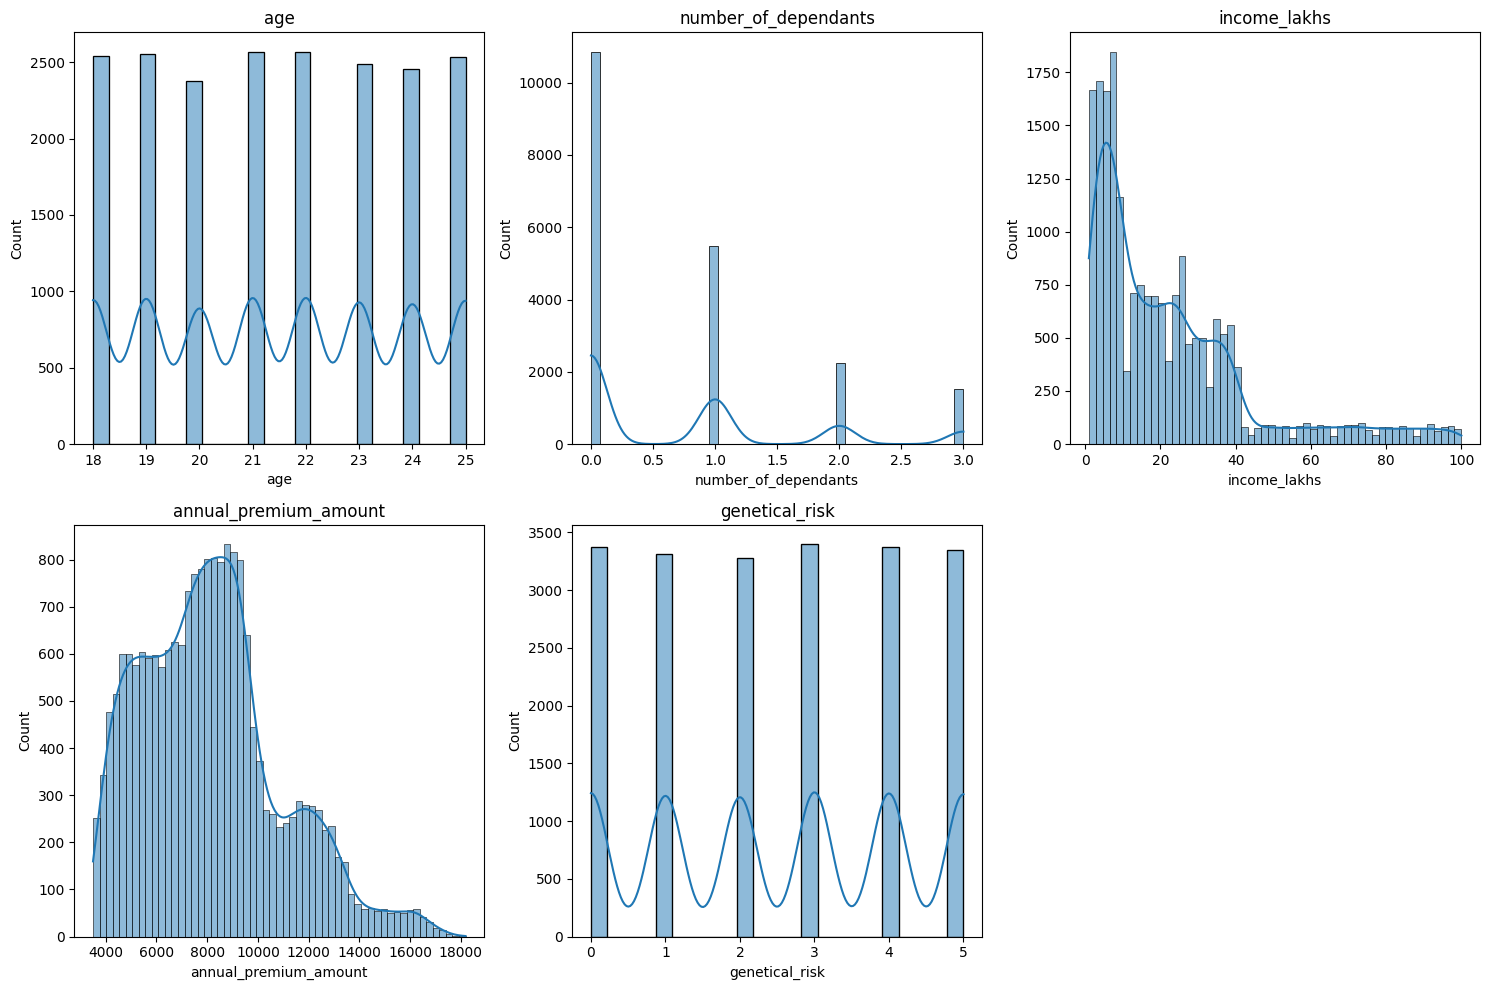

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size to ensure plots are not squeezed

for i, column in enumerate(num_cols):
    # Locating the correct subplot using integer division and modulus
    ax = axs[i // 3, i % 3]  # Row index is i//3, column index is i%3
    sns.histplot(df1[column], kde=True, ax=ax)
    ax.set_title(column)

# If the last subplot axis is unused, you can turn it off
if len(num_cols) % 3 != 0:
    for j in range(len(num_cols), 6):  # This will disable any unused subplots
        axs.flat[j].set_visible(False)


plt.tight_layout()
plt.savefig("github repository/EDA_young/distribution_numeric_features_young.png")
plt.show()

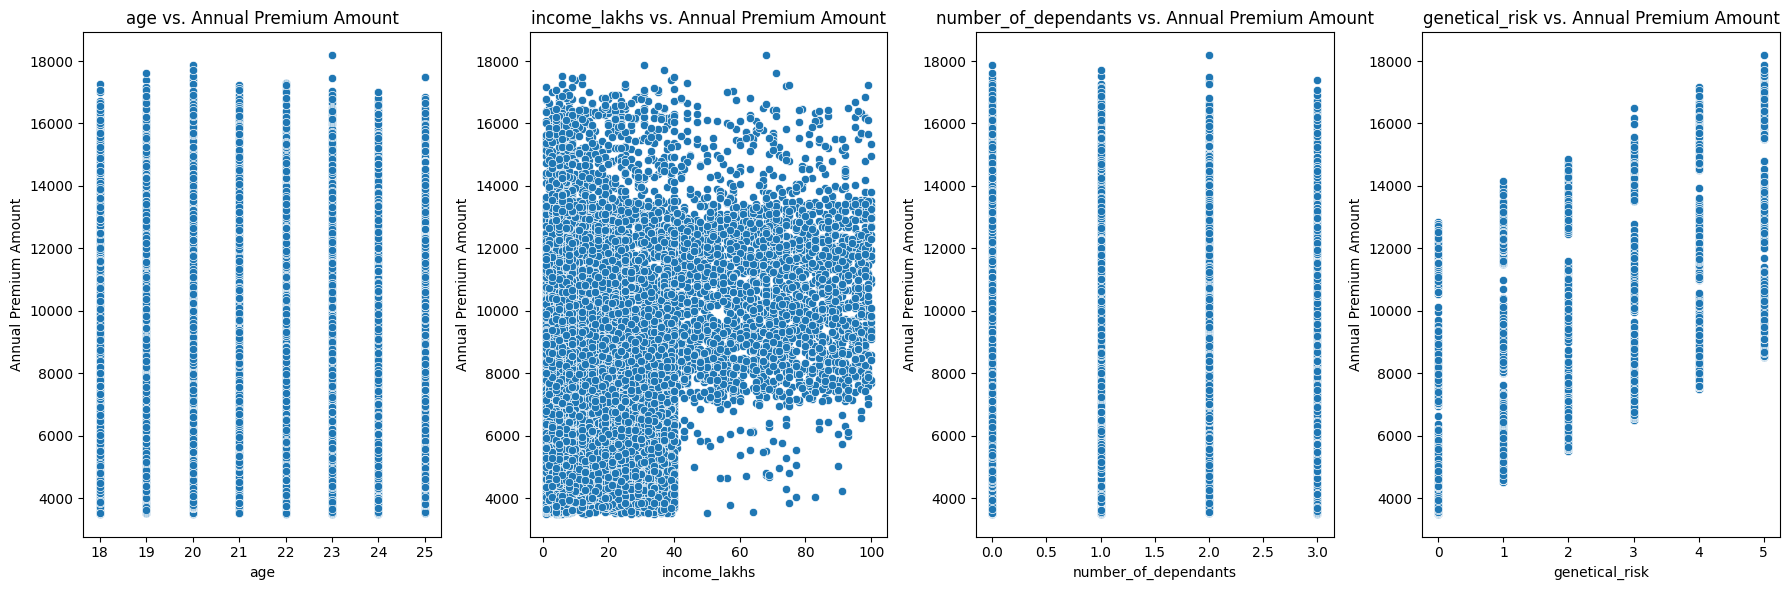

In [33]:
# Scatter Plot
numeric_features = ['age', 'income_lakhs', 'number_of_dependants', 'genetical_risk']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df1[column], y=df1['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout() 
plt.savefig("github repository/EDA_young/Scatter_plot_numeric_features_young.png")
plt.show()

#### Categorical Columns

In [34]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df1[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [35]:
df1['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df1['smoking_status'].unique()

C:\Users\Ashok\AppData\Local\Temp\ipykernel_14588\2056166140.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

#### Feature Engineering

In [36]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


#### Calculation Of Risk Score based on medical_history

In [37]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df1[['disease1', 'disease2']] = df1['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df1['disease1'] = df1['disease1'].fillna('none')
df1['disease2'] = df1['disease2'].fillna('none')
Diseases = ['disease1', 'disease2']
df1['total_risk_score'] = 0
for disease in Diseases:
    df1['total_risk_score'] += df1[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df1['total_risk_score'].max()
min_score = df1['total_risk_score'].min()
df1['normalized_risk_score'] = (df1['total_risk_score'] - min_score) / (max_score - min_score)
df1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


#### Encoding Text Columns

In [38]:
df1['insurance_plan'] = df1['insurance_plan'].map({'Gold': 3,'Silver': 2,'Bronze': 1})

In [39]:
df1.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [40]:
df1['income_level'] = df1['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [41]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df2 = pd.get_dummies(df1, columns=nominal_cols, drop_first=True, dtype=int)
df2.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   genetical_risk                   20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male            

#### Feature Selection

In [43]:
df3 = df2.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df3.head(3)   

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


### VIF calculation for Multicollinearity

In [44]:
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

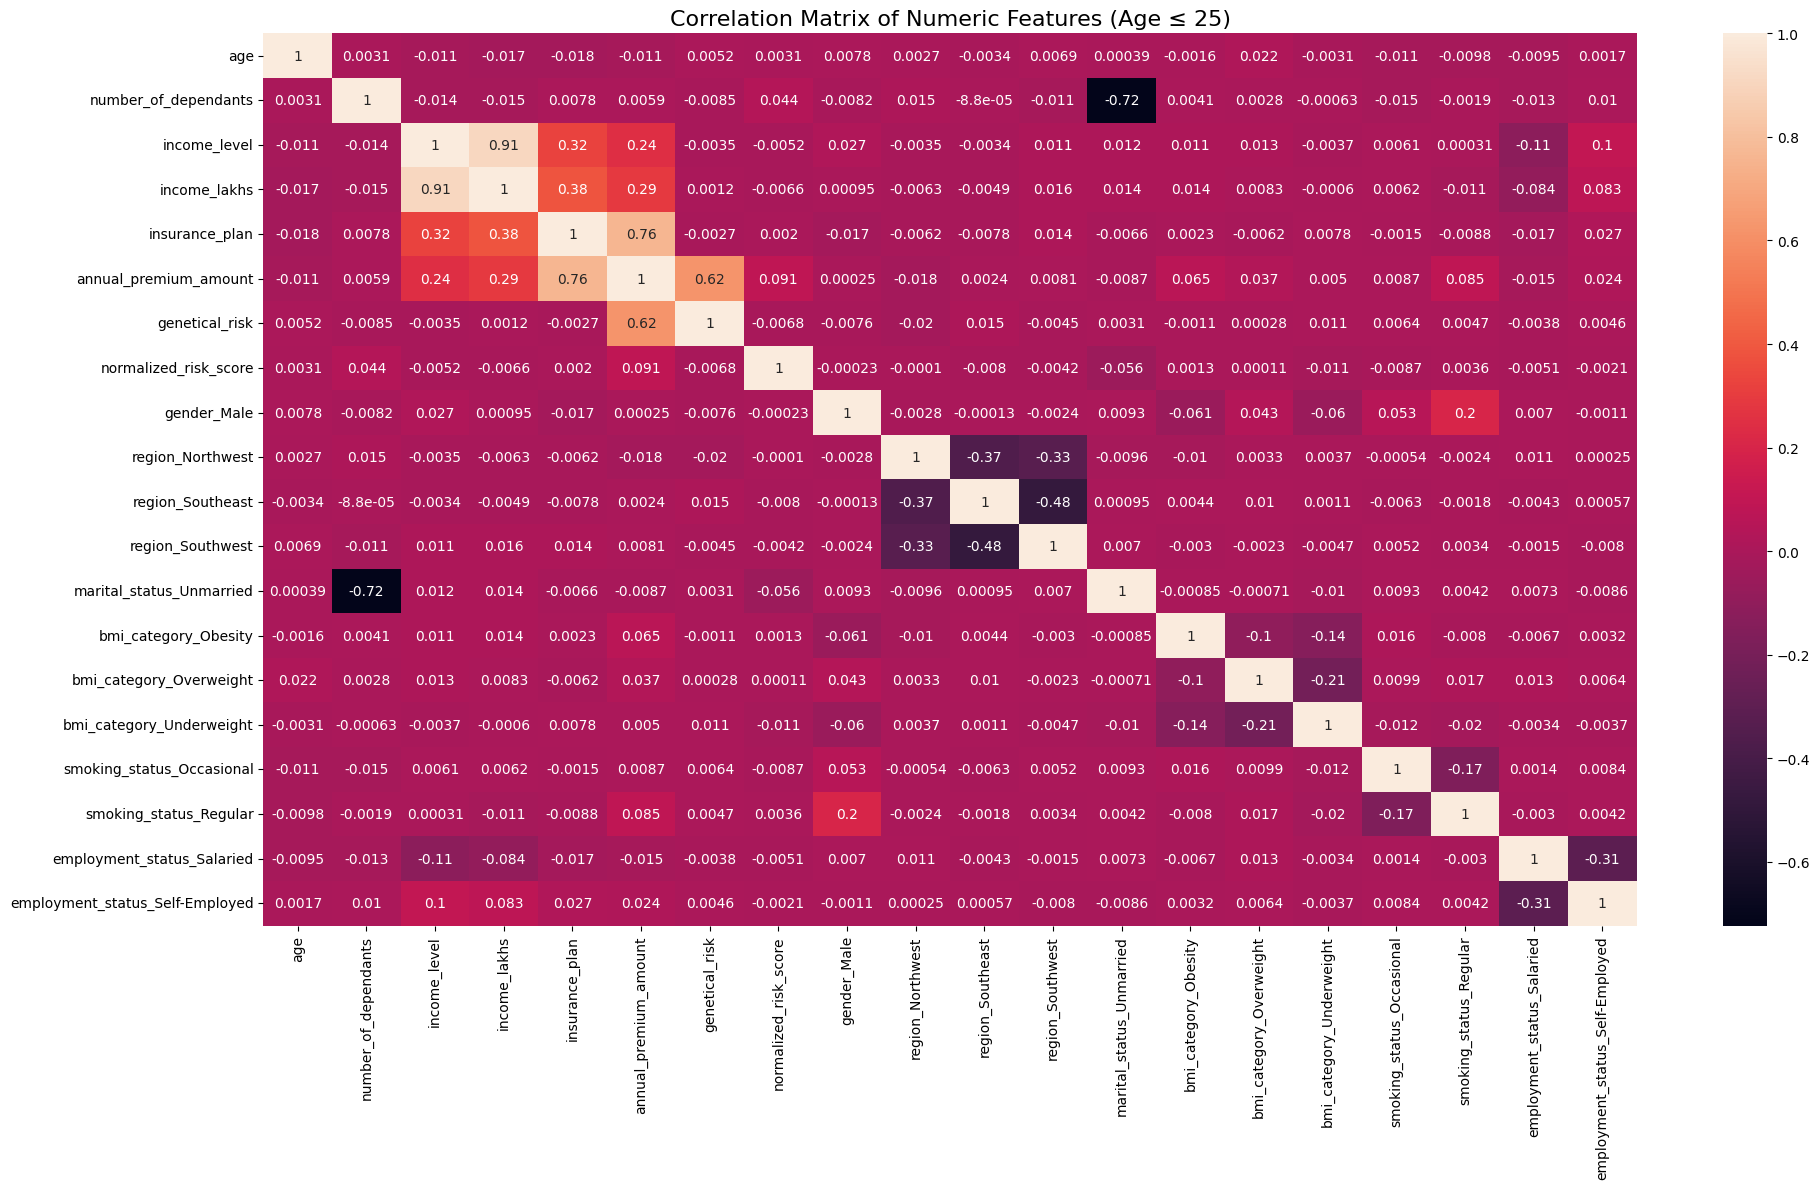

In [45]:
cm = df3.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.title("Correlation Matrix of Numeric Features (Age ≤ 25)", fontsize=16)
plt.tight_layout()
plt.savefig("github repository/EDA_young/Correlation_matrix_numeric_features_young.png")
plt.show()

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
x = df3.drop('annual_premium_amount', axis='columns')
y = df3['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

x[cols_to_scale] = scaler.fit_transform(x[cols_to_scale])
x.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
calculate_vif(x)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [51]:
# Drop income_level
calculate_vif(x.drop('income_level',axis='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [52]:
# Finally dropping income_level column to reduce multicollinearity

x_reduced = x.drop('income_level',axis='columns')

#### Model training

In [53]:
x_train,x_test,y_train,y_test = train_test_split(x_reduced, y, test_size=0.30, random_state=10)

print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


#### Linear Regression Model

In [54]:
model_linear = LinearRegression()
model_linear.fit(x_train,y_train)
test_score = model_linear.score(x_test,y_test)
train_score = model_linear.score(x_train,y_train)
train_score,test_score

(0.988297900194864, 0.9887263253056615)

In [55]:
np.set_printoptions(suppress=True, precision=6)
model_linear.coef_

array([  -7.229032,   19.536182,   -1.264528, 7001.125261, 4996.988728,
       1109.148365,    8.177988,    1.677353,   -3.275327,    6.317095,
         16.068972,  812.844929,  400.375598,  107.529819,  205.069661,
        610.98328 ,    0.038784,   -5.242018])

##### Feature Importance Analysis

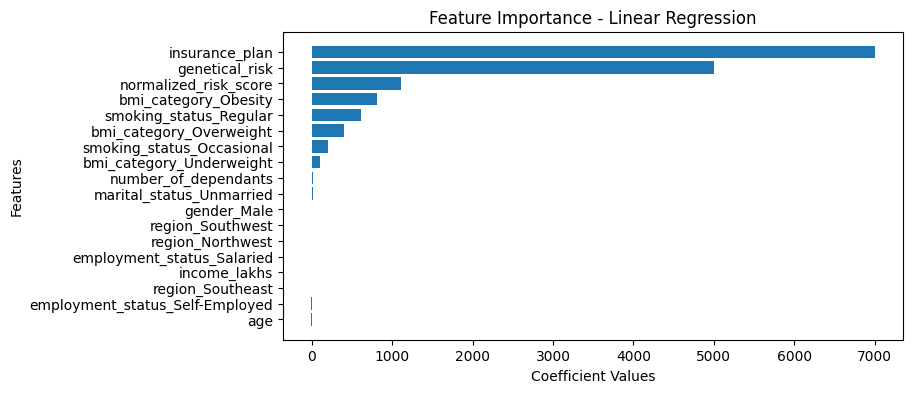

In [56]:
feature_imp = model_linear.coef_

coef_df = pd.DataFrame(feature_imp,index=x_train.columns,columns = ['Coefficients']).sort_values(ascending = True,by='Coefficients')

plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'])
plt.title("Feature Importance - Linear Regression")
plt.xlabel("Coefficient Values")
plt.ylabel("Features")

plt.savefig("github repository/EDA_young/feature_importance_linear_regression_barchart_young.png")
plt.show()

#### XGBOOST Regression Model

In [57]:
import xgboost as xgb
model_xgb= xgb.XGBRegressor(n_estimators = 20,max_depth=3)
model_xgb.fit(x_train,y_train)
model_xgb.score(x_test,y_test)

0.9876989126205444

##### Tuning and evaluating an XGBoost regression model using cross-validation

In [58]:
model_xgb = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)
random_search.best_score_

np.float64(0.9879226088523865)

In [59]:
best_model = model_linear

##### Calculation of prediction error and percentage error

In [60]:
y_pred = best_model.predict(x_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


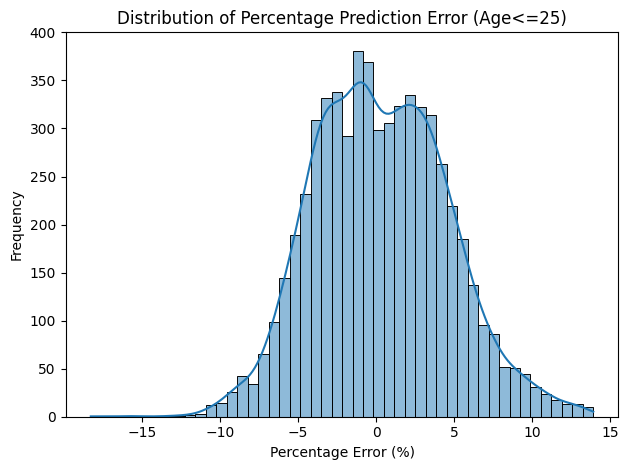

In [73]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Percentage Prediction Error (Age<=25)')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("github repository/EDA_young/percentage_error_distribution_young.png")
plt.show()

As per business requrement, Any prediction with more than ±10% error is considered “extreme” i.e

Errors within ±10% → acceptable.

Errors beyond ±10% → problematic. We will find the records where prediction error is greater than 10%.

In [63]:
extreme_error_threshold = 10  # Assumption that the threshold for error is 10% as per discussion with business team
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
12669,3985,4394.013230,409.013230,10.263820
2918,4517,5001.927338,484.927338,10.735606
17084,3562,3995.394401,433.394401,12.167165
7181,3630,4005.052340,375.052340,10.332020
12285,3532,3998.012625,466.012625,13.194015


In [65]:
extreme_results_df.shape

(129, 4)

In [66]:
extreme_results_df.shape[0]*100/x_test.shape[0]

2.140723531364089

This shows that there is approximately 2.14% extreme error out of x_test data. Approximately 2.14% of test predictions exceed the extreme error threshold.

In [67]:
extreme_errors_df = x_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.0,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.0,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0


##### Comparing feature distributions for cases with extreme prediction errors vs the overall test set, feature by feature

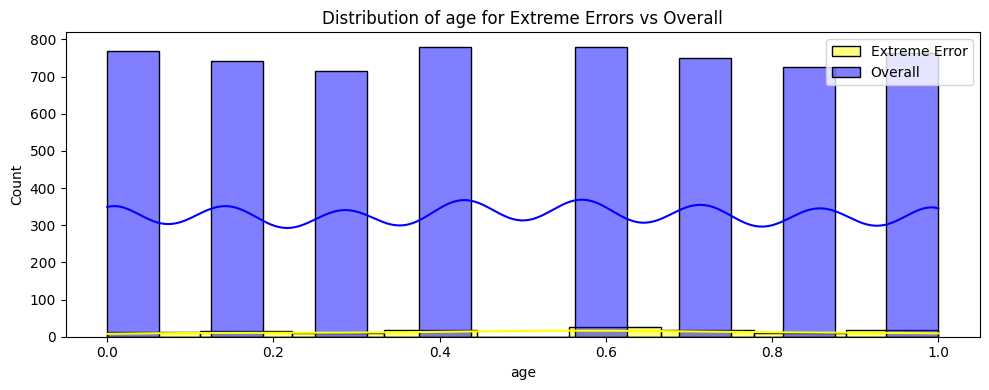

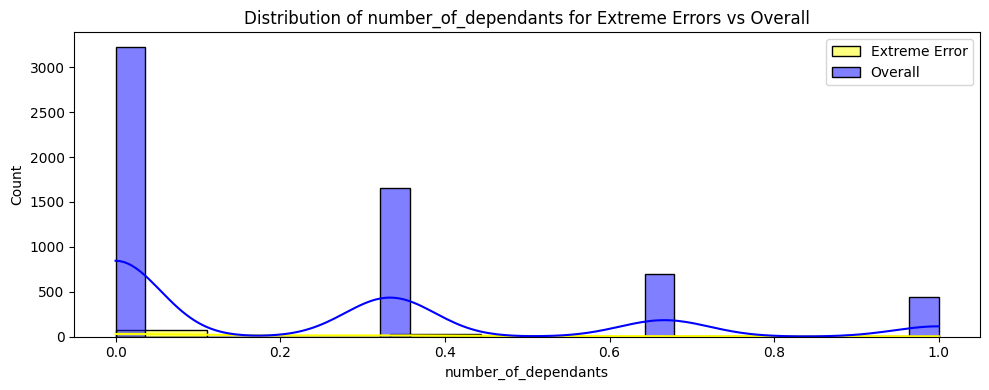

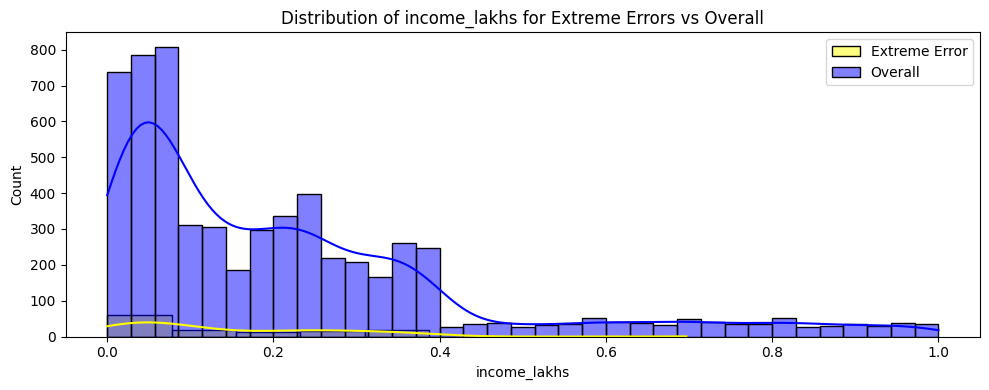

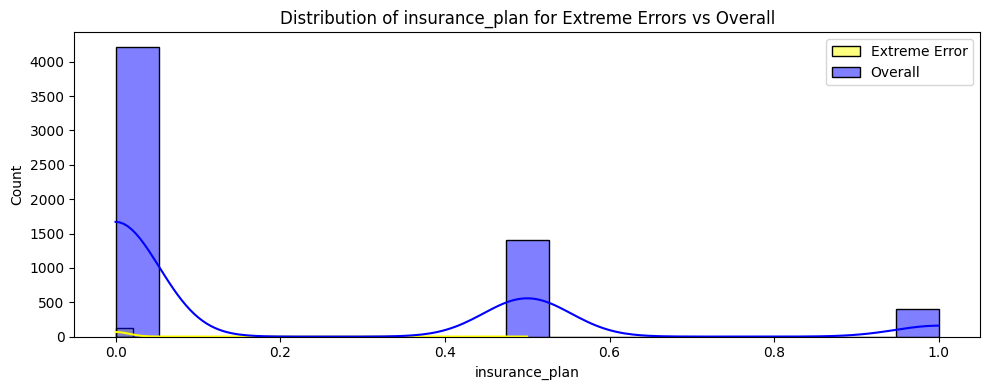

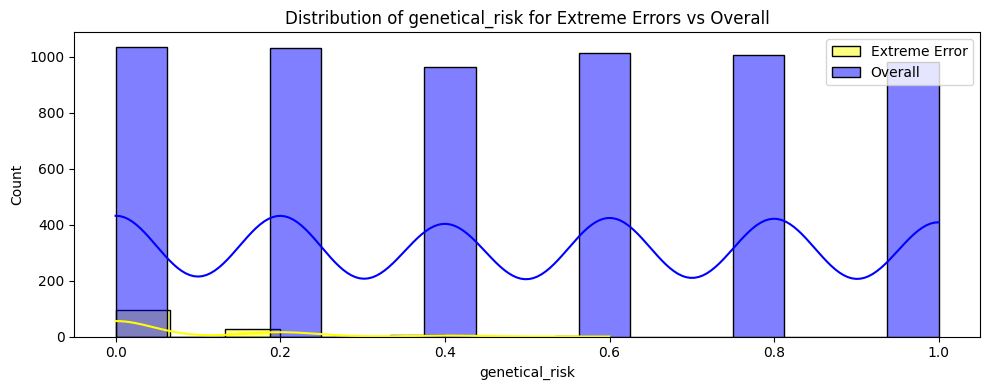

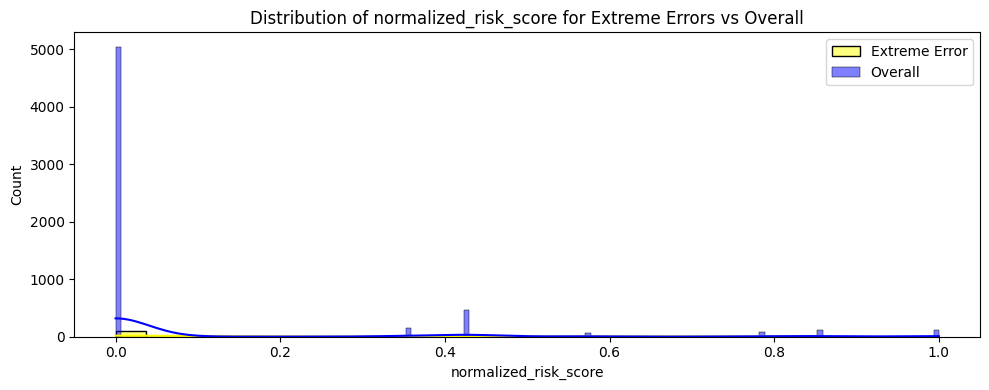

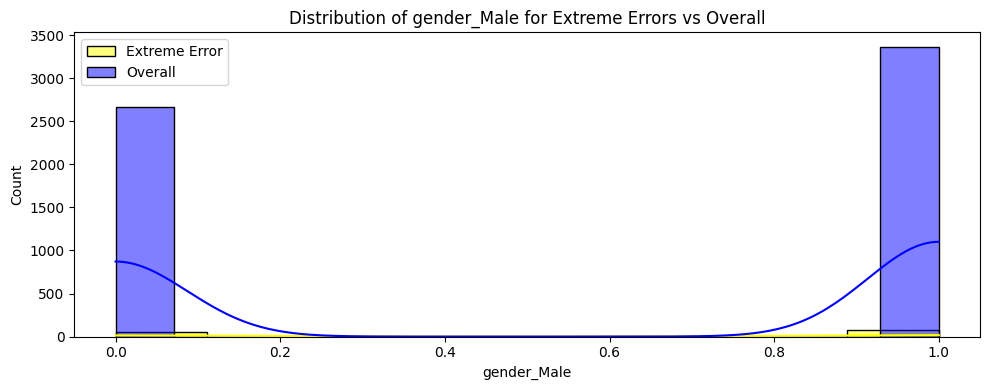

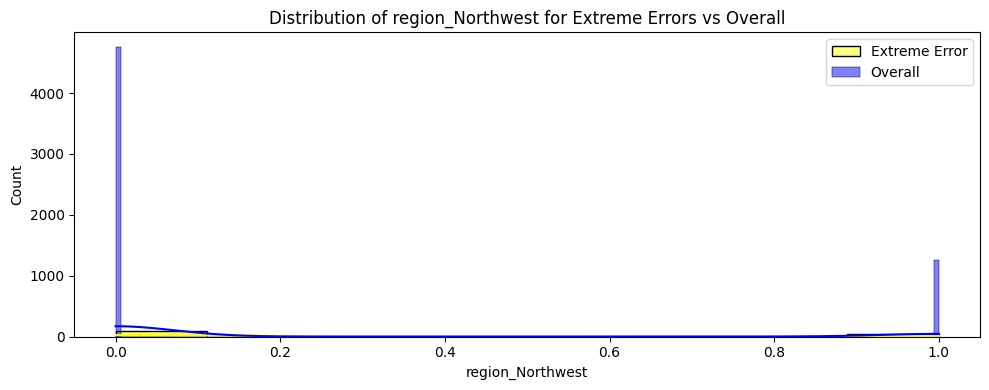

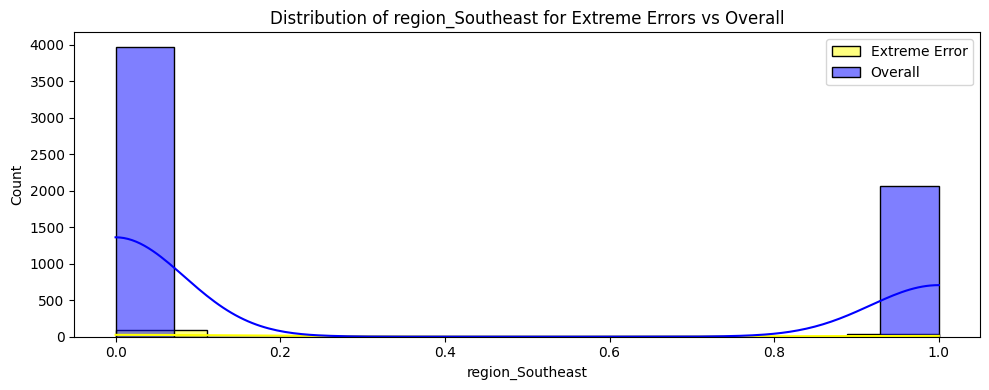

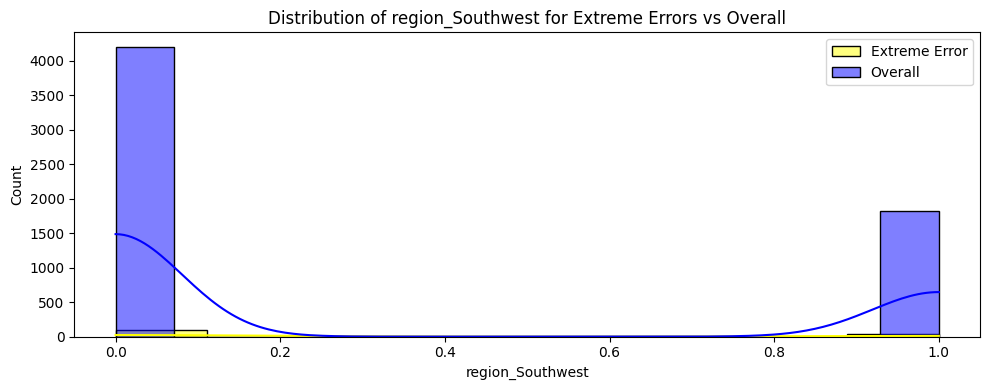

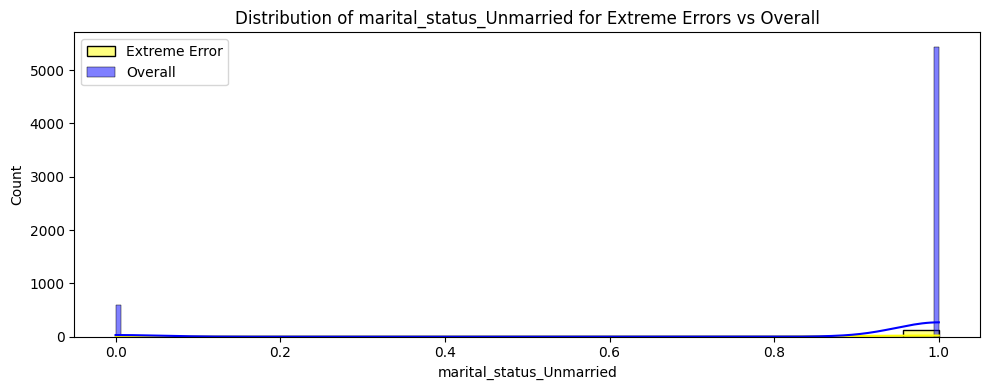

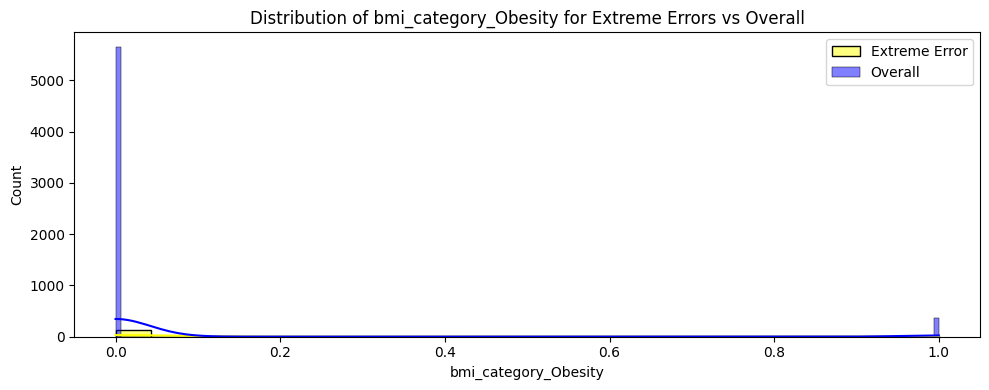

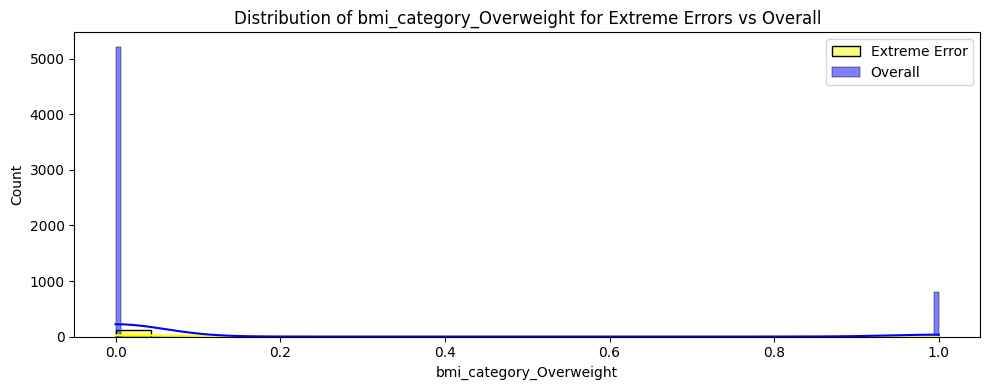

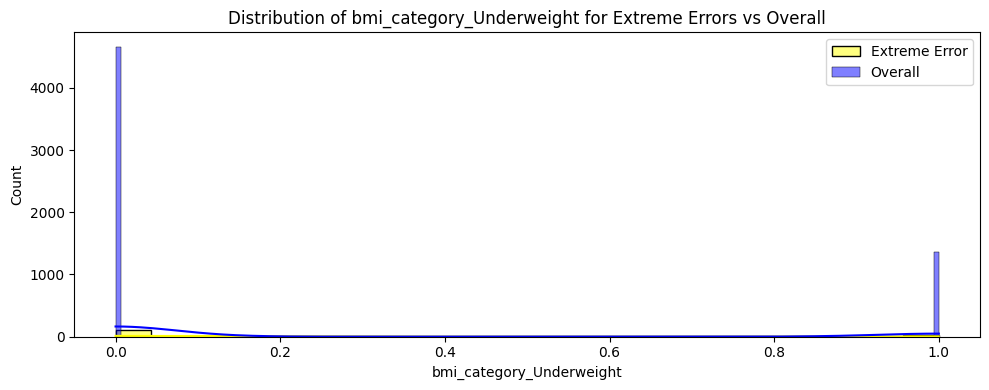

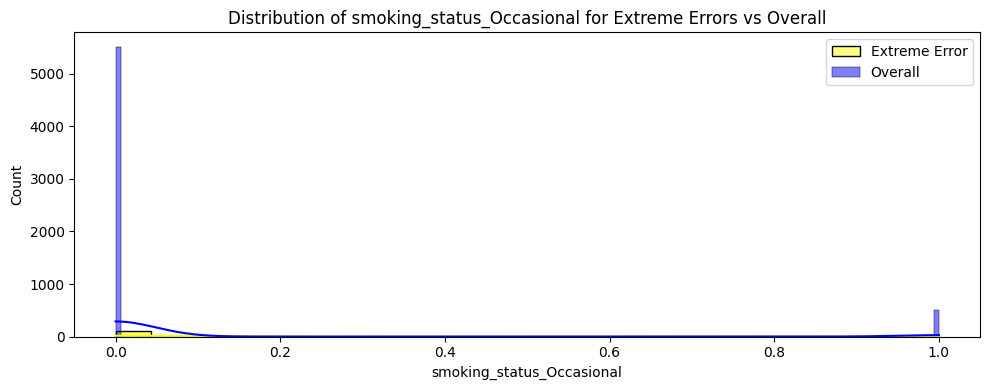

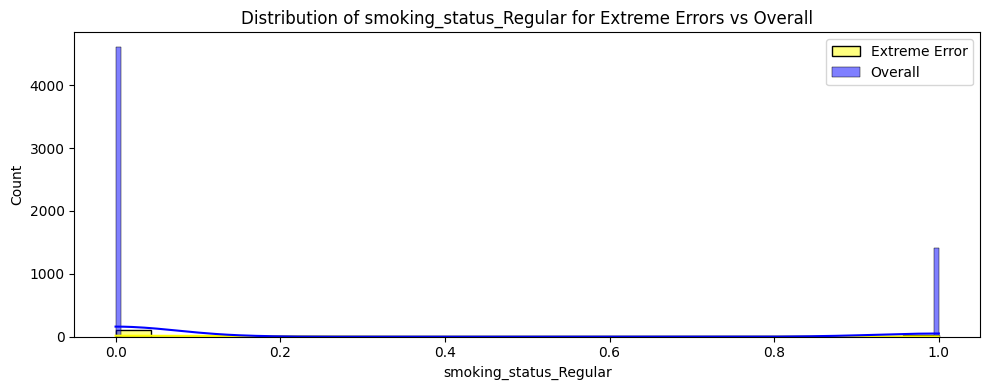

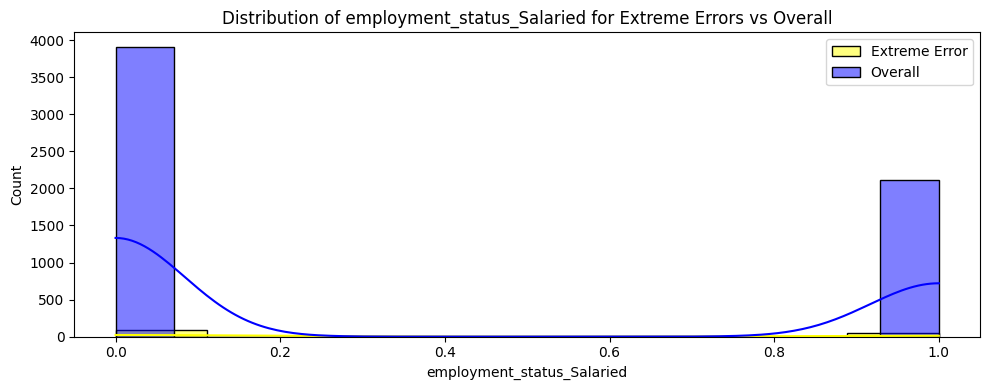

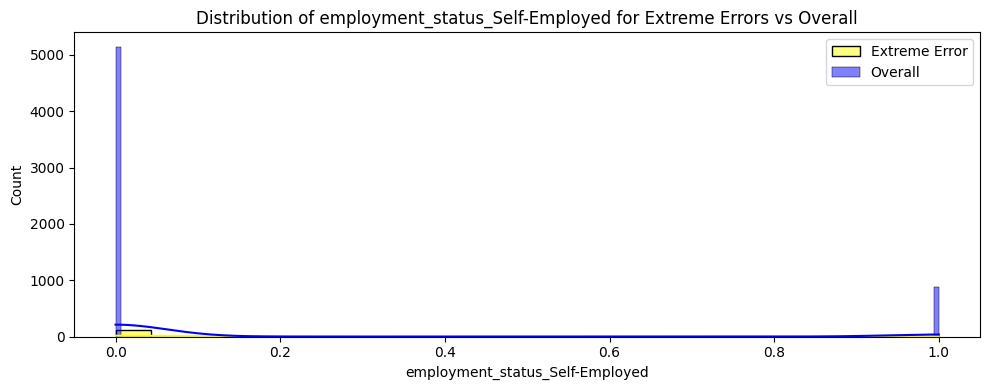

In [69]:
for features in x_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[features],color='yellow',label='Extreme Error',kde = True)
    sns.histplot(x_test[features], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {features} for Extreme Errors vs Overall')

    plt.tight_layout()
    plt.savefig(f'github repository/EDA_young/extreme_vs_overall_{features}.png')
    plt.show()

Comparison with earlier results

Before (initial model):

Approximately 30% of test predictions exceeded the ±10% error threshold, indicating significant reliability issues.

After (segmented model with age <=25):

Only 2.14% of test predictions now exceed the extreme error threshold, showing a substantial improvement in model accuracy and stability.

#### Export the Model

In [70]:
from joblib import dump

dump(best_model, "artifacts/premium_model_young.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/premium_scaler_young.joblib")

['artifacts/premium_scaler_young.joblib']